In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import KeyedVectors

from tqdm import tqdm
import os

from collections import Counter

In [82]:
data = pd.read_csv('dataset.csv')
print(data.shape)
data.head(2)

(109248, 16)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,"esl, literacy",Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23
1,1,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,fl,2016-10-25 09:22:10,grades_6_8,"history_civics, health_sports","civics_government, team_sports",Wanted: Projector for Hungry Learners,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.0,1


# 1 EDA

No._Approved:  92706 ,  84.85830404217927 %
Not_Approved:  16542 ,  15.141695957820739 %


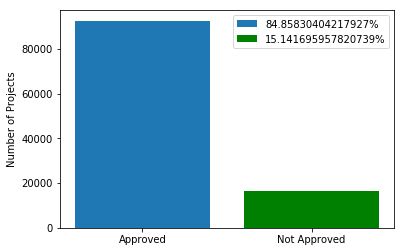

In [83]:
y_value_counts = data['project_is_approved'].value_counts()
Approved=((y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100)
Not_Approved=((y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100)
print("No._Approved: ", y_value_counts[1], ", ", Approved,"%")
print("Not_Approved: ", y_value_counts[0], ", ", Not_Approved,"%")

plt.bar(['Approved'],[y_value_counts[1]], label=str(Approved)+'%')
plt.bar(['Not Approved'],[y_value_counts[0]], color='g',label=str(Not_Approved)+'%')
plt.ylabel('Number of Projects')
plt.legend()

# 1.1 School State

   state_code  approved_projects_%
8          de            89.795918
28         nd            88.811189
47         wa            87.617823
35         oh            87.515201
30         nh            87.356322
   state_code  approved_projects_%
18         la            83.124478
26         mt            81.632653
43         tx            81.314224
7          dc            80.232558
46         vt            80.000000


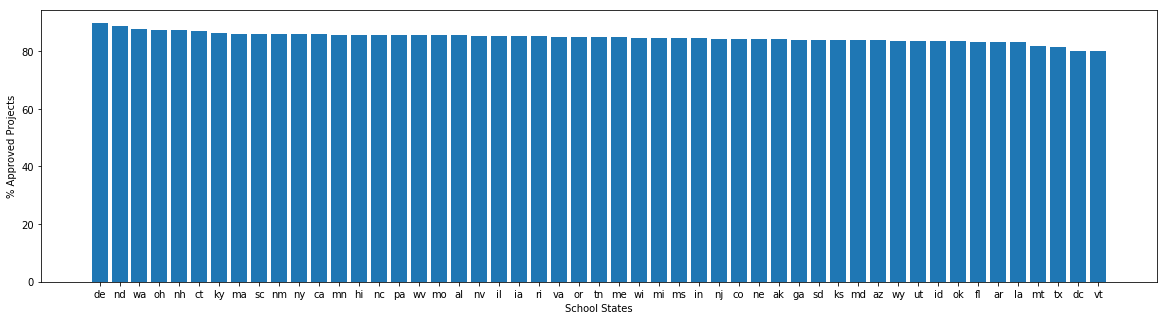

In [84]:
df1 = pd.DataFrame(data.groupby("school_state")["project_is_approved"].agg(np.mean)*100).reset_index()
df1.columns = ['state_code', 'approved_projects_%']
df1.sort_values(['approved_projects_%'], ascending=False, inplace=True)
print(df1.head(5))
print(df1.tail(5))

plt.figure(figsize=(20,5))
plt.bar(df1['state_code'],df1['approved_projects_%'])
plt.xlabel('School States')
plt.ylabel('% Approved Projects')
plt.show()

# 1.2 Grade

  project_grade_category  approved_projects_%  No._Project_Proposals
3          grades_prek_2            84.875071                  44225
0             grades_3_5            85.437704                  37137
1             grades_6_8            84.252201                  16923
2            grades_9_12            83.763568                  10963


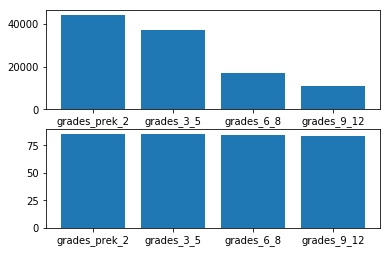

In [85]:
df1 = pd.DataFrame(data.groupby("project_grade_category")["project_is_approved"].agg(np.mean)*100).reset_index()
df1.columns = ['project_grade_category', 'approved_projects_%']
df2=pd.DataFrame(data.groupby("project_grade_category").agg(np.size)).reset_index()
df1['No._Project_Proposals']=df2['project_is_approved']
df1.sort_values(['No._Project_Proposals'], ascending=False, inplace=True)
print(df1.head(5))

fig,pl=plt.subplots(2)
pl[0].bar(df1['project_grade_category'],df1['No._Project_Proposals'])
pl[1].bar(df1['project_grade_category'],df1['approved_projects_%'])
plt.show()

# 1.3 Subject Categories

         project_subject_categories  approved_projects_%  \
24                literacy_language            86.746988   
32                     math_science            81.952905   
28  literacy_language, math_science            86.943154   
8                     health_sports            84.897317   
40                   music_the arts            85.501931   

    No._Project_Proposals  
24                  23655  
32                  17072  
28                  14636  
8                   10177  
40                   5180  


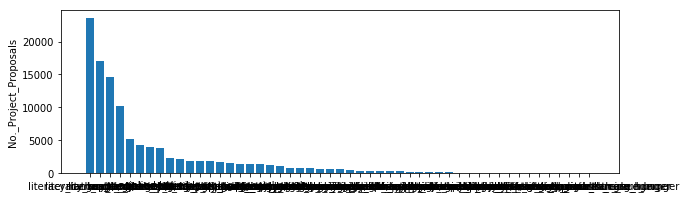

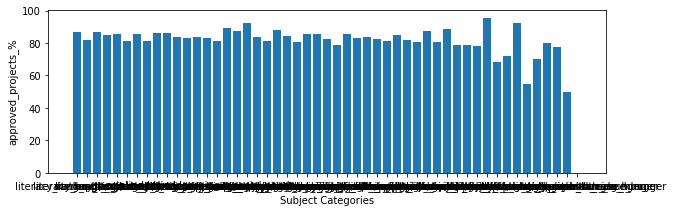

In [86]:
df1 = pd.DataFrame(data.groupby("project_subject_categories")["project_is_approved"].agg(np.mean)*100).reset_index()
df1.columns = ['project_subject_categories', 'approved_projects_%']
df2=pd.DataFrame(data.groupby("project_subject_categories").agg(np.size)).reset_index()
df1['No._Project_Proposals']=df2['project_is_approved']
df1.sort_values(['No._Project_Proposals'], ascending=False, inplace=True)
print(df1.head(5))

#fig,pl=plt.subplots(2)
plt.figure(figsize=(10,3))
plt.bar(df1['project_subject_categories'],df1['No._Project_Proposals'])
plt.ylabel('No._Project_Proposals')
plt.show()

plt.figure(figsize=(10,3))
plt.bar(df1['project_subject_categories'],df1['approved_projects_%'])
plt.ylabel('approved_projects_%')
plt.xlabel('Subject Categories')
plt.show()

# 1.4 Teacher Prefix

  teacher_prefix  approved_projects_%  No._Project_Proposals
2           Mrs.            85.556642                  57272
3            Ms.            84.353741                  38955
1            Mr.            84.147258                  10648
4        Teacher            79.533898                   2360
0            Dr.            69.230769                     13


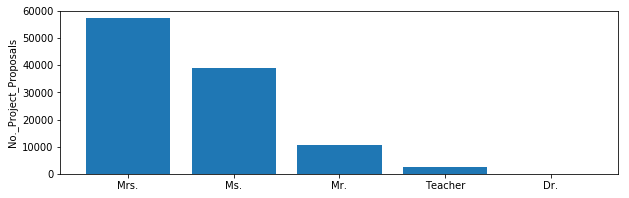

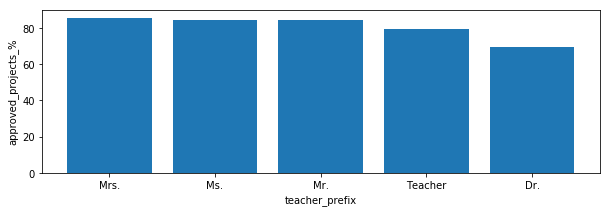

In [129]:
df1 = pd.DataFrame(data.groupby("teacher_prefix")["project_is_approved"].agg(np.mean)*100).reset_index()
df1.columns = ['teacher_prefix', 'approved_projects_%']
df2=pd.DataFrame(data.groupby("teacher_prefix").agg(np.size)).reset_index()
df1['No._Project_Proposals']=df2['project_is_approved']
df1.sort_values(['No._Project_Proposals'], ascending=False, inplace=True)
print(df1.head(5))

#fig,pl=plt.subplots(2)
plt.figure(figsize=(10,3))
plt.bar(df1['teacher_prefix'],df1['No._Project_Proposals'])
plt.ylabel('No._Project_Proposals')
plt.show()

plt.figure(figsize=(10,3))
plt.bar(df1['teacher_prefix'],df1['approved_projects_%'])
plt.ylabel('approved_projects_%')
plt.xlabel('teacher_prefix')
plt.show()

# 1.5 No. of words in Project Titles

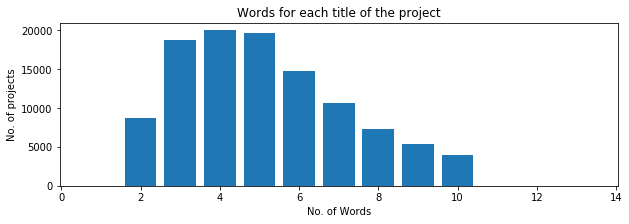

In [87]:
word_count = data['project_title'].str.split().apply(len)
#df2=pd.DataFrame(word_count)
#df2.to_csv('title_word_count.csv')
df1=pd.DataFrame((word_count).value_counts())

x=df1.index
y=df1['project_title']

plt.figure(figsize=(10,3))
plt.bar(x, y)
plt.ylabel('No. of projects')
plt.xlabel('No. of Words')
plt.title('Words for each title of the project')
plt.show()

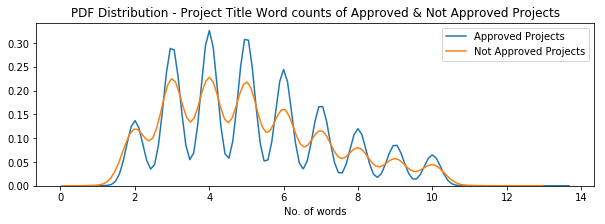

In [88]:
approved_word_count = data[data['project_is_approved']==1]['project_title'].str.split().apply(len)
not_approved_word_count = data[data['project_is_approved']==0]['project_title'].str.split().apply(len)

plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(not_approved_word_count, hist=False, label="Not Approved Projects")
plt.xlabel('No. of words')
plt.title('PDF Distribution - Project Title Word counts of Approved & Not Approved Projects')
plt.legend()
plt.show()

# 1.6 No. of words in Project Essays

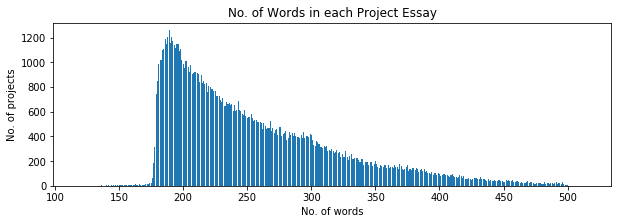

In [90]:
essay_word_count = data['essay'].str.split().apply(len)
#df4=pd.DataFrame(essay_word_count)
#df4.to_csv('essay_word_count.csv')
df1=pd.DataFrame((essay_word_count).value_counts())

x=df1.index
y=df1['essay']
plt.figure(figsize=(10,3))
plt.bar(x, y)
plt.ylabel('No. of projects')
plt.xlabel('No. of words')
plt.title('No. of Words in each Project Essay')
plt.show()

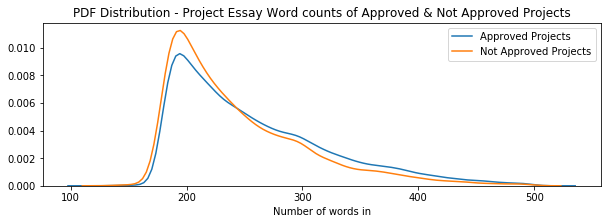

In [91]:
approved_essay_word_count = data[data['project_is_approved']==1]['essay'].str.split().apply(len)
not_approved_essay_word_count = data[data['project_is_approved']==0]['essay'].str.split().apply(len)

plt.figure(figsize=(10,3))
sns.distplot(approved_essay_word_count , hist=False, label="Approved Projects")
sns.distplot(not_approved_essay_word_count , hist=False, label="Not Approved Projects")
plt.title('PDF Distribution - Project Essay Word counts of Approved & Not Approved Projects')
plt.xlabel('Number of words in')
plt.legend()
plt.show()

# 1.7 No. of Previously Posted Prjects by Teachers

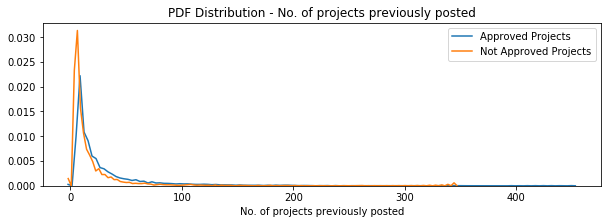

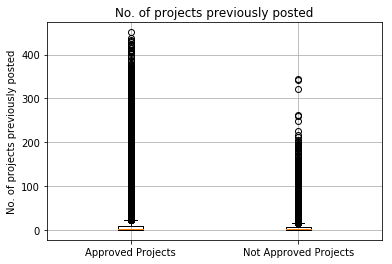

In [92]:
#No. of projects previously posted by teachers whose projects got approved for posting on website
approved_projects_previously_posted = data[data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values

#No. of projects previously posted by teachers whose projects got approved for posting on website
not_approved_projects_previously_posted = data[data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values

#PDF Distribution
plt.figure(figsize=(10,3))
sns.distplot(approved_projects_previously_posted , hist=False, label="Approved Projects")
sns.distplot(not_approved_projects_previously_posted , hist=False, label="Not Approved Projects")
plt.title('PDF Distribution - No. of projects previously posted')
plt.xlabel('No. of projects previously posted')
plt.legend()
plt.show()

#Box Plot
plt.boxplot([approved_projects_previously_posted, not_approved_projects_previously_posted])
plt.title('No. of projects previously posted')
plt.xticks([1,2],('Approved Projects','Not Approved Projects'))
plt.ylabel('No. of projects previously posted')
plt.grid()
plt.show()

# 1.8 Funding Price

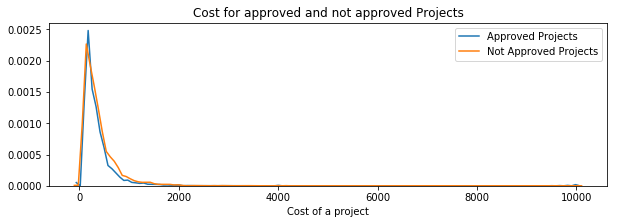

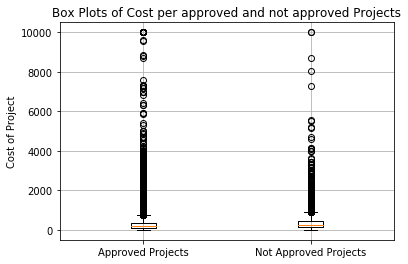

In [93]:
approved_project_price = data[data['project_is_approved']==1]['price']
not_approved_project_price = data[data['project_is_approved']==0]['price']

plt.figure(figsize=(10,3))
sns.distplot(approved_project_price, hist=False, label="Approved Projects")
sns.distplot(not_approved_project_price, hist=False, label="Not Approved Projects")
plt.title('Cost for approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

plt.boxplot([approved_project_price, not_approved_project_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Not Approved Projects'))
plt.ylabel('Cost of Project')
plt.grid()
plt.show()

# 1.9 Resources Quantity

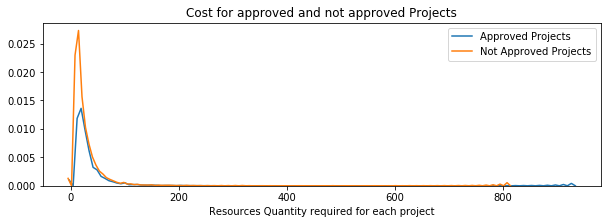

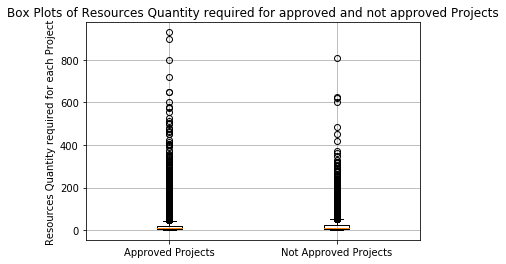

In [121]:
approved_project_quantity = data[data['project_is_approved']==1]['quantity']
not_approved_project_quantity = data[data['project_is_approved']==0]['quantity']

plt.figure(figsize=(10,3))
sns.distplot(approved_project_quantity, hist=False, label="Approved Projects")
sns.distplot(not_approved_project_quantity, hist=False, label="Not Approved Projects")
plt.title('Cost for approved and not approved Projects')
plt.xlabel('Resources Quantity required for each project')
plt.legend()
plt.show()

plt.boxplot([approved_project_quantity, not_approved_project_quantity])
plt.title('Box Plots of Resources Quantity required for approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Not Approved Projects'))
plt.ylabel('Resources Quantity required for each Project')
plt.grid()
plt.show()

# Submission Month & Year

  project_year_month  approved_projects_%  No._Project_Proposals
0              16-04            86.547619                    840
1              16-05            86.648025                   5722
2              16-06            85.649078                   5477
3              16-07            82.409794                   7760
4              16-08            84.609610                  19980
   project_year_month  approved_projects_%  No._Project_Proposals
8               16-12            86.419194                   6627
9               17-01            85.310108                   9013
10              17-02            86.199190                   7159
11              17-03            85.791578                   8502
12              17-04            84.165478                   5608


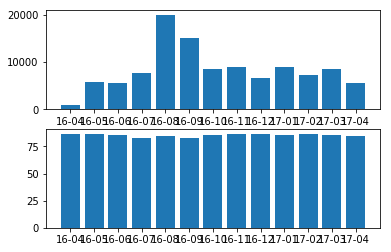

In [128]:
#Capturing Submission Month & Year from Submission Timestamp
data['project_year_month']=data['project_submitted_datetime'].str[2:7]

df1 = pd.DataFrame(data.groupby("project_year_month")["project_is_approved"].agg(np.mean)*100).reset_index()
df1.columns = ['project_year_month', 'approved_projects_%']
df2=pd.DataFrame(data.groupby("project_year_month").agg(np.size)).reset_index()
df1['No._Project_Proposals']=df2['project_is_approved']
df1.sort_values(['project_year_month'], inplace=True)
print(df1.head(5))
print(df1.tail(5))

fig,pl=plt.subplots(2)
pl[0].bar(df1['project_year_month'],df1['No._Project_Proposals'])
pl[1].bar(df1['project_year_month'],df1['approved_projects_%'])
plt.show()

# 2 Pre Processing

In [95]:
data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,"esl, literacy",Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23


# 2.1 Categorical features

In [96]:
#School State
data['school_state'] = data['school_state'].str.lower()
data['school_state'].values

array(['in', 'fl', 'az', ..., 'nj', 'ny', 'va'], dtype=object)

In [134]:
#Teacher_Prefix
data['teacher_prefix'] = data['teacher_prefix'].str.lower()
data['teacher_prefix'] = data['teacher_prefix'].str.replace('.','')
data['teacher_prefix'].values

array(['mrs', 'mr', 'ms', ..., 'mrs', 'mrs', 'ms'], dtype=object)

In [97]:
#Project_Subject_Catgories
data['project_subject_categories'] = data['project_subject_categories'].str.replace(' & ','_')
data['project_subject_categories'] = data['project_subject_categories'].str.replace('Warmth, Care_Hunger','Warmth_Care_Hunger')
data['project_subject_categories'] = data['project_subject_categories'].str.lower()
data['project_subject_categories'].values

array(['literacy_language', 'history_civics, health_sports',
       'health_sports', ..., 'literacy_language, math_science',
       'health_sports, special needs', 'applied learning, math_science'],
      dtype=object)

In [98]:
#Project_Subject_Subcatgories
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.replace(', ','/')
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.replace(' & ','_')
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.replace(' ','_')
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.replace('/',', ')
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.replace('Warmth, Care_Hunger','Warmth_Care_Hunger')
data['project_subject_subcategories'] = data['project_subject_subcategories'].str.lower()
data['project_subject_subcategories'].values

array(['esl, literacy', 'civics_government, team_sports',
       'health_wellness, team_sports', ..., 'literacy, mathematics',
       'health_wellness, special_needs',
       'college_career_prep, mathematics'], dtype=object)

In [99]:
#Project_Grade_Category
data['project_grade_category'] = data['project_grade_category'].str.replace(' ','_')
data['project_grade_category'] = data['project_grade_category'].str.replace('-','_')
data['project_grade_category'] = data['project_grade_category'].str.lower()
data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

# 2.2 Text Features

In [102]:
# https://stackoverflow.com/a/47091490/4084039, https://gist.github.com/sebleier/554280
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stopwords= ['my', 'me', 'i', 'we', 'myself', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',  'how', 'so',\
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', \
            'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'to', 'from', 'in', 'out', 'on', 'off', 'over', 'under','then', 'once', 'here', 'there', 'when', 'where', 'why',\
            's', 't', 'don', "don't", 'should', "should've", 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def preprocess_title_text(text_data):
    preprocessed_text = []
    for sentance in text_data:
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [101]:
preprocessed_titles = preprocess_text(data['project_title'].values)

In [103]:
preprocessed_essays = preprocess_text(data['essay'].values)

In [104]:
preprocessed_res_summary = preprocess_text(data['project_resource_summary'].values)

In [105]:
data['preprocessed_titles']=preprocessed_titles
data['preprocessed_essays']=preprocessed_essays
data['preprocessed_res_summary']=preprocessed_res_summary
data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,preprocessed_titles,preprocessed_essays,preprocessed_res_summary
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,"esl, literacy",Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23,educational support for english learners at home,my students are english learners that are work...,my students need opportunities to practice beg...


In [130]:
data=data.drop(['Unnamed: 0','id','essay','project_resource_summary','project_title','project_submitted_datetime'],axis=1)

data.head(1)

,teacher_id,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,preprocessed_titles,preprocessed_essays,preprocessed_res_summary,project_year_month
0,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,in,grades_prek_2,literacy_language,"esl, literacy",0,0,154.6,23,educational support for english learners at home,my students are english learners that are work...,my students need opportunities to practice beg...,16-12


In [131]:
data.shape

(109248, 14)

In [135]:
data.to_csv('data_preprocessed.csv')